# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

---

### Сравнение времени активности пользователей в Москве и Санкт-Петербурге

- Автор: Дерновой П.В.
- Дата: 11.07.2025

### Цели и задачи проекта

Оценить время активности пользователей в Москве и Санкт-Петербурге

### Описание данных

В проекте рассматриваем данные о чтении и прослушивании контента в сервисе Яндекс Книги в городах `Москва` и `Санкт-Петербург`.

Описание таблицы:
- `city` - Город
- `puid` - идентификатор пользователя
- `hours` - суммарное время активности пользователя (час)

### Содержимое проекта
1. **Загрузка данных**
    - Загружаем данные для анализа
    - проверка данных на пропуски и дубликаты.
    - разделение датасета на группы сравнения
    - Статистические показатели групп сравнения
3. **Проека гипотезы**
    - Формирование гипотезы
    - Проверка гипотезы
5. **Аналитическая записка**
    - Выводы
---

## Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
# Импортируем необходимые модули
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from math import ceil
# Модули для проведения тестов
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest

### Загрузка данных и знакомство с ними

In [2]:
# Задаем расположение данных в сети
PATH_1 = 'https://code.s3.yandex.net/datasets/'
# Загружаем данные
df_orig  = pd.read_csv (PATH_1 + 'yandex_knigi_data.csv' ) 

In [3]:
#Посмотрим первые строки датасета
display(df_orig.head(5))
#Посмотрим информацию по датасету
display(df_orig.info())

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


None

**Датасет содержит информаци по активности в городах Москва и Санкт-Петербург для 8784 пользователей**

### Коррекцция данных

Видим что пропусков в данных нет.
Но присутствует столбец который дублирует индекс строк

In [4]:
#Удалим лишний столбец который дублирует индекс строк
df_main = df_orig.drop(columns='Unnamed: 0')
# Выводим первые строки датафрейма на экран
display(df_main.head(5))

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434


In [5]:
print(f'Кол-во явных дубликатов: {df_main.duplicated().sum()}')
print(f'Кол-во дубликатов в столбцах puid и city: {df_main.duplicated(subset=['puid', 'city']).sum()}')
print(f'Кол-во дубликатов в столбце puid: {df_main.duplicated(subset=['puid']).sum()}')

Кол-во явных дубликатов: 0
Кол-во дубликатов в столбцах puid и city: 0
Кол-во дубликатов в столбце puid: 244


Делаем вывод что 244 пользователя наблюдаются в Санкт-Петербурге и Москве.

После разделения датасета на два (`Москва`, `Санкт-Петербург`) это будет являтся пересечением, поэтому удалим данные этих пользователей.

In [6]:
df_main = df_main.drop_duplicates(subset=['puid', 'city'])

### Группы сравнения

#### Разделение датасета

In [7]:
#Разделим датасет на два по Названию города
df_msk = df_main[df_main['city']=='Москва']
df_spb = df_main[df_main['city']=='Санкт-Петербург']

#### Анализ групп сравнения

In [8]:
# статистические данные по обоим датасетам
print(df_msk.describe())
print(df_spb.describe())

               puid        hours
count  6.234000e+03  6234.000000
mean   1.123926e+13    10.881092
std    1.121386e+14    36.851683
min    9.668000e+03     0.000018
25%    3.139885e+08     0.059903
50%    8.730945e+08     0.924498
75%    1.510930e+09     5.939972
max    1.130000e+15   857.209373
               puid        hours
count  2.550000e+03  2550.000000
mean   7.977401e+12    11.592691
std    9.462180e+13    39.704993
min    1.049230e+05     0.000025
25%    3.442209e+08     0.080002
50%    9.133665e+08     0.984781
75%    1.530662e+09     6.509072
max    1.130000e+15   978.764775


Промежуточные выводы:
1. Кол-во пользователей
    - Москва - 6234
    - Санкт-Петербург - 2550
2. В обоих группах сравнения наблюдается процентиль 50 в районе 0,95 часа, процентиль 75 около 6 часов. Что косвенно указывает на малое колличество пользователей с активностью более 6 часов.

## Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [9]:
msk_mean_hours = round(df_msk['hours'].mean(),2)
spb_mean_hours = round(df_spb['hours'].mean(),2)
mtr = round((spb_mean_hours/msk_mean_hours -1)*100, 2)

print(f'Среднее значение в МСК {msk_mean_hours}')
print(f'Среднее значение в СПБ {spb_mean_hours}')
print(f'в СПБ среднее больше на {round(spb_mean_hours - msk_mean_hours,2)}ч ({mtr} %)')

Среднее значение в МСК 10.88
Среднее значение в СПБ 11.59
в СПБ среднее больше на 0.71ч (6.53 %)


In [10]:
alpha = 0.05
results = st.ttest_ind(df_spb['hours'], df_msk['hours'], alternative= 'greater', equal_var = False) 

p_value = results.pvalue
print(p_value)

if p_value > alpha:
    print('Нулевая гипотеза о равенстве средней активности пользователей не может быть опровергнута')
else:
    print('Нулевая гипотеза о равенстве средней активности пользователей опровергается')

0.21823507084569593
Нулевая гипотеза о равенстве средней активности пользователей не может быть опровергнута


## Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



По результатам анализа данных можно сделать следущие выводы:

- Среднее время активности пользователей в Санкт-петербурге выше чем в Москве на 0.71ч (6.53 %)

- Для проверки статистической значимости полученных результатов выбранн односторонний t-тест Уэлча (уровень статистической значимости = 0,05).

- Результат теста (p-value = 0.218) не опровергает нулевую гипотезу, что показывает превышение средней активности пользователей в Санк-Петербурге **статистически незначимым**.

- Такие результаты связаны с разнице в группах сравнения (

    - Санкт-Петербург - `2550` пользователей
    - Москва - `6234` пользователей

<font size = 5>**Вывод: Среднее время активности пользователей в Москве и Санкт-Петербурге схоже**.</font>


----

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## Опишите цели исследования.

Проверить увеличение конверсии покупателей в покупку после внедренения новой версии сайта интернет-магазина BitMotion Kit

## Загрузите данные, оцените их целостность.


In [11]:
# Загружаем данные
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [12]:
# Рассмотрим данные
display (participants.head(5))
print(participants.info())

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB
None


При рассмотрении наблюдается селедующее:
- Пропуски данных отсутствуют
- В датасете содержаться результаты нескольких исследований

Рассмотрим более внимательно содержимое всех столбцов

In [13]:
# Проверим уникальные значения в столбцах
print('Содержимое столбца ab_test', participants['ab_test'].unique())
print('Содержимое столбца group', participants['group'].unique())

Содержимое столбца ab_test ['interface_eu_test' 'recommender_system_test']
Содержимое столбца group ['B' 'A']


In [14]:
# Рассмотрим данные по каждому исследованию
print('---------------------------------------------')
for i in participants['ab_test'].unique():
    print(f'Название A/B-теста : {i}')
    print(f'    Колличество пользователей в группе A: {participants['user_id'][(participants['ab_test']==i) & (participants['group']=='A')].value_counts().sum()}')
    print(f'    Колличество пользователей в группе B: {participants['user_id'][(participants['ab_test']==i) & (participants['group']=='B')].value_counts().sum()}')
    print('---------------------------------------------')



---------------------------------------------
Название A/B-теста : interface_eu_test
    Колличество пользователей в группе A: 5383
    Колличество пользователей в группе B: 5467
---------------------------------------------
Название A/B-теста : recommender_system_test
    Колличество пользователей в группе A: 2747
    Колличество пользователей в группе B: 928
---------------------------------------------


## По таблице `ab_test_participants` оцените корректность проведения теста:

### Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [15]:
# Пересечения пользователей в конкурирующих тестах
int_df = participants.groupby('user_id').agg({'ab_test': 'nunique'}).query('ab_test > 1').reset_index()
print(f'Кол-во пересечений пользователей в конкурирующих тестах: {len(int_df)} пользователей')

# Фильтруем и удаляем пересечения
participants_filtered = participants[~participants['user_id'].isin(int_df['user_id'])]

# Проверяем результат
int_df = participants_filtered.groupby('user_id').agg({'ab_test': 'nunique'}).query('ab_test > 1')
print(f'Кол-во пересечений пользователей в конкурирующих тестах (после очистки): {len(int_df)} пользователей')

# Выделим пользователей учавствущих в тесте interface_eu_test 
participants_ab = participants_filtered[participants_filtered['ab_test']== 'interface_eu_test']

Кол-во пересечений пользователей в конкурирующих тестах: 887 пользователей
Кол-во пересечений пользователей в конкурирующих тестах (после очистки): 0 пользователей


In [16]:
# Проверяем дубликаты по user_id
print(f' кол-во дубликатов в датасете: {participants_ab['user_id'].duplicated().sum()}')

 кол-во дубликатов в датасете: 0


Колличество пользователей в группе A: 4952
Колличество пользователей в группе B: 5011
    Разность в кол-ве пользователей составляет 59 (1.19%)


Text(0, 0.5, 'Тип устройства')

<Figure size 600x400 with 0 Axes>

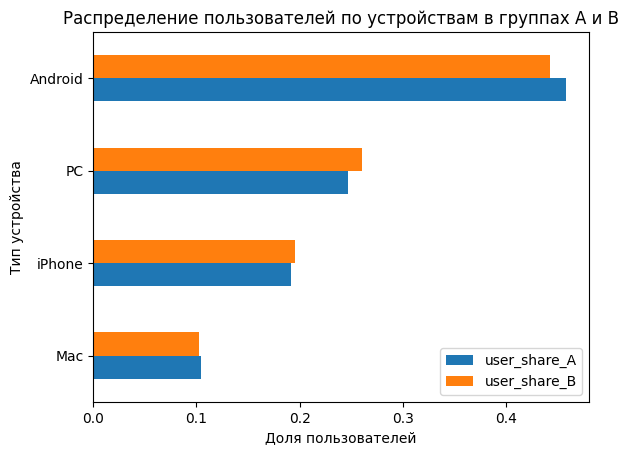

In [17]:
# Разделяем датасет на друппы A и B
participants_A = participants_ab[participants_ab['group']=='A']
participants_B = participants_ab[participants_ab['group']=='B']

# Определим размер групп
print(f'Колличество пользователей в группе A: {len(participants_A)}')
print(f'Колличество пользователей в группе B: {len(participants_B)}')
print(f'    Разность в кол-ве пользователей составляет {len(participants_B)-len(participants_A)} ({round((len(participants_B)/len(participants_A)-1)*100,2)}%)')


# Группируем пользователей по типу устройств для каждой группы
participants_A_device = participants_A.groupby(['user_id', 'device'])['group'].agg('count').reset_index().groupby('device')['user_id'].agg('count').to_frame().sort_values(by = 'user_id', ascending=True)
participants_B_device = participants_B.groupby(['user_id', 'device'])['group'].agg('count').reset_index().groupby('device')['user_id'].agg('count').to_frame().sort_values(by = 'user_id', ascending=True)
# Расчитываем долю типа устройств относительно всех пользователей для каждой группы
participants_A_device['user_share']=participants_A_device['user_id']/participants_A_device['user_id'].sum()
participants_B_device['user_share']=participants_B_device['user_id']/participants_B_device['user_id'].sum()

#Объединяем полученные данные каждой группы в один датасет
user_device = participants_A_device.join(participants_B_device, on = 'device', lsuffix='_A', rsuffix='_B')

#Строим диаграмму распределения
plt.figure(figsize=(6,4))
user_device.plot(kind='barh', y = ['user_share_A', 'user_share_B'], legend = True, rot = 0)
plt.title('Распределение пользователей по устройствам в группах A и B')
plt.xlabel('Доля пользователей')
plt.ylabel('Тип устройства')

**Проиежуточные выводы:**
- Колличество пользователей в группе A: 4952
- Колличество пользователей в группе B: 5011
- Разность в кол-ве пользователей составляет 59 (1.19%)
- Распределение долей по типам устройств в двух группах совпадают

**Можно сделать вывод что группы A и B сопостовимы, тест прошел нормально**

### Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [18]:
# Фильтруем датасет по пользователям которые учавствовали в тестировании
events_filtered = events[events['user_id'].isin(participants_ab['user_id'])]

print(f'После фильтрации в датасете осталось {len(events_filtered)} записей о активности пользователей входящих в группы тестирования')

После фильтрации в датасете осталось 73815 записей о активности пользователей входящих в группы тестирования


- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [19]:
# Добавим столбец с датой регистрации в датасет
user_registration = events_filtered[events_filtered['event_name']=='registration'].pivot_table(index='user_id', values = 'event_dt', aggfunc='min').reset_index()
user_registration = user_registration.rename(columns = {'event_dt' : 'registration'})
events_filtered = events_filtered.merge(user_registration, how='left',  left_on='user_id', right_on = 'user_id')

# Расчитываем life_time
events_filtered['life_time'] = events_filtered['event_dt'] - events_filtered['registration']
# Оставляем только события, лайф тайм которых меньше 7 дней
events_filtered_seven_d = events_filtered[events_filtered['life_time'] < '7 days']

print(f'В итоговом датасете содержиться {len(events_filtered_seven_d)} событий')

В итоговом датасете содержиться 63805 событий


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [20]:
# Функция расчета выборки
def calculate_sample_size(base_conversion, power=0.8, significance=0.05):
    # Конвертируем проценты в доли
    p1 = base_conversion / 100  # базовая конверсия
    p2 = p1 * 1.2  # предполагаем увеличение на 20%
    
    # Критические значения для заданного уровня значимости и мощности
    z_alpha = st.norm.ppf(1 - significance / 2)  # для двустороннего теста
    z_beta = st.norm.ppf(power)
    
    # Расчет размера выборки
    effect_size = p2 - p1
    pooled_p = (p1 + p2) / 2
    
    n = (2 * pooled_p * (1 - pooled_p) * (z_alpha + z_beta)**2) / effect_size**2
    
    return int(ceil(n))

In [21]:
# Параметры теста
base_conversion = 30  # базовый показатель конверсии в процентах
power=0.8
significance=0.05

# Вычисляем необходимый размер выборки
required_sample_size = calculate_sample_size(base_conversion, power, significance)

# Определим размер групп
print(f'Колличество пользователей в группе A: {len(participants_A)}')
print(f'Колличество пользователей в группе B: {len(participants_B)}')
print(f'Необходимый размер выборки для каждой группы: {required_sample_size}')

if (len(participants_A) > required_sample_size) & (len(participants_B) > required_sample_size):
    print('Размер выборок достатачен для получения статистически значимых результатов A/B-теста')
else:
    print('Размер выборок не достатачен для получения статистически значимых результатов A/B-теста')

Колличество пользователей в группе A: 4952
Колличество пользователей в группе B: 5011
Необходимый размер выборки для каждой группы: 965
Размер выборок достатачен для получения статистически значимых результатов A/B-теста


- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [22]:
# Объединим датасеты с активностью пользователей и участниками исследования
events_merge = events_filtered_seven_d.merge(participants_filtered, on = 'user_id')

In [23]:
# Расчитаем для каждой группы кол-во пользователей сделавших покупку, общее количество посетителей, долю платящих пользователей.
user_gr_A_all = events_merge['user_id'][events_merge['group']=='A'].nunique()
user_gr_A_purchase = events_merge['user_id'][(events_merge['group']=='A') & (events_merge['event_name'] == 'purchase')].nunique()
user_gr_A_per = round(user_gr_A_purchase/user_gr_A_all, 4)

user_gr_B_all = events_merge['user_id'][events_merge['group']=='B'].nunique()
user_gr_B_purchase = events_merge['user_id'][(events_merge['group']=='B') & (events_merge['event_name'] == 'purchase')].nunique()
user_gr_B_per = round(user_gr_B_purchase/user_gr_B_all, 4)

print(f'Группа A: \n    Общее колличество пользователей: {user_gr_A_all}\n    Колличество пользователей сделавших покупку: {user_gr_A_purchase}\n    Процент платящих пользователей: {round(user_gr_A_per*100,2)}%')
print(f'Группа B: \n    Общее колличество пользователей: {user_gr_B_all}\n    Колличество пользователей сделавших покупку: {user_gr_B_purchase}\n    Доля платящих пользователей: {round(user_gr_B_per*100,2)}%')
print(f'Разница в доля платящих пользователей: {round((user_gr_B_per - user_gr_A_per)*100,2)}%')


Группа A: 
    Общее колличество пользователей: 4952
    Колличество пользователей сделавших покупку: 1377
    Процент платящих пользователей: 27.81%
Группа B: 
    Общее колличество пользователей: 5011
    Колличество пользователей сделавших покупку: 1480
    Доля платящих пользователей: 29.54%
Разница в доля платящих пользователей: 1.73%


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

**Промежуточные выводы**

Полльзовательская активность в тестовой группе выросла на 1,73%

## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

### Сформулируем гипотезу:
- H0: доли пользователей сделавших покупку в двух группах значимо не различается в двух выборках
- H1: доли пользователей сделавших покупку в двух группах значимо различается в двух выборках

### Проверяем гипотезу
Для проверки гипотезы будем использовать односторонний z-test

In [24]:

m_a = user_gr_A_purchase
m_b = user_gr_B_purchase
n_a = user_gr_A_all
n_b= user_gr_B_all

# проводим тест
ztest_result, p_value = proportions_ztest([m_b,m_a],[n_b,n_a], alternative='larger')

print(f'p_value = {p_value}')
if p_value > alpha:
    print(f'Нулевая гипотеза о том что, доли пользователей сделавших покупку в двух группах значимо не различается в двух выборках, не может быть опровергнута')
else:
    print(f'Нулевая гипотеза о том что, доля пользователей сделавших покупку в двух группах значимо не различается в двух выборках,  опровергается')

p_value = 0.028262547212292124
Нулевая гипотеза о том что, доля пользователей сделавших покупку в двух группах значимо не различается в двух выборках,  опровергается


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

- **Характеристики проведённого эксперимента:**
    - **Количество задействованных пользователей:** В тесте участвовало в районе 10 000 пользователей (4 952 в группе A и 5 011 в группе B).

- **Влияние нового интерфейса сайта интернет-магазина BitMotion Kit:**  
Ключевая метрика — **конверсия пользователей в покупку**:
    - В группе A: **27,81%**.  
    - В группе B: **29,54%**.  
    - **Разница между группами:** **1.73%** в пользу группы B.  

- **Статистическая значимость:**  
    - **Значение p-value:** **0.0282** (меньше уровня значимости 0.05).  
    - **Вывод:** Различие в конверсии между группами **статистически значимо**.  

- **Рекомендация:**  
Новая версия сайта **увеличила конверсию пользователей в покупку на `1,73%`**, и этот эффект подтверждён статистически.    


- **Итоговое решение:**  
    - **Внедрять новую версию сайта интернет-магазина BitMotion Kit** можно.